In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data
import torchvision.utils as utils
import os


In [2]:
#dataset path
data_path_train = "./data/training_adj"
data_path_test = "./data/testing"

In [3]:
# data transform, you can add different transform methods and resize image to any size
img_size = 224
transform = transforms.Compose([
                       transforms.Resize((img_size,img_size)),
                       transforms.ToTensor()
                       ])

#build dataset
dataset = datasets.ImageFolder(root=data_path_train,transform=transform)

# spilt your data into train and val
TOTAL_SIZE = len(dataset)
ratio = 0.9
train_len = round(TOTAL_SIZE * ratio)
valid_len = round(TOTAL_SIZE * (1-ratio))
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, valid_len])

#build dataloader
train_data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=4)
val_data_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=True,  num_workers=4)

#check dataset
print(dataset)
print(dataset.class_to_idx)

Dataset ImageFolder
    Number of datapoints: 2769
    Root location: ./data/training_adj
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [4]:
#train function
def train(model, criterion, optimizer):
    model.train()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in train_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # backward + optimize
        loss.backward()
        optimizer.step()

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data).cpu()
        
    avg_loss = total_loss / len(train_data_loader)
    accuracy = total_correct.double() / len(train_dataset) * 100

    print('Training Accuracy: {:.4f}% Training Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy ,avg_loss

#validation function
def valid(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    
    # Iterate over data
    for inputs, labels in val_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        total_loss += loss.item()
        total_correct += torch.sum(preds == labels.data).cpu()
        
    avg_loss = total_loss / len(val_data_loader)
    accuracy = total_correct.double() / len(val_dataset) * 100

    print('Validation Accuracy: {:.4f}% Validation Loss: {:.4f}'.format(accuracy, avg_loss))
    return accuracy ,avg_loss

In [5]:
# using gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

In [6]:
class ResNet_18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet_18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [7]:
####################  implement your optimizer ###################################
## you can use any training methods if you want (ex:lr decay, weight decay.....)
model = ResNet_18(3, 4)
learning_rate = 0.00001
epochs =  10
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

train_losss=[]
train_accs=[]
val_losss=[]
val_accs=[]

# start training
model.to(device=device)
acc_best = 0.0

print('--------------start training--------------')
for epoch in range(1, epochs+1):
    
    print('epoch:', epoch)
    accuracy_train ,loss_train=train(model, criterion, optimizer)
    accuracy_val ,loss_val  = valid(model, criterion)    
    
    train_losss.append(loss_train)
    train_accs.append(accuracy_train)
    val_losss.append(loss_val)
    val_accs.append(accuracy_val)
    
    if accuracy_val > acc_best:
        acc_best = accuracy_val
        print("model saved")
        # save the model
        torch.save(model, "model.pth")

--------------start training--------------
epoch: 1
Training Accuracy: 58.2665% Training Loss: 0.9950
Validation Accuracy: 70.0361% Validation Loss: 0.8176
model saved
epoch: 2
Training Accuracy: 73.3547% Training Loss: 0.6823
Validation Accuracy: 78.3394% Validation Loss: 0.6265
model saved
epoch: 3
Training Accuracy: 86.3563% Training Loss: 0.4317
Validation Accuracy: 78.7004% Validation Loss: 0.5257
model saved
epoch: 4
Training Accuracy: 94.6228% Training Loss: 0.2212
Validation Accuracy: 82.6715% Validation Loss: 0.4687
model saved
epoch: 5
Training Accuracy: 98.1140% Training Loss: 0.1048
Validation Accuracy: 83.3935% Validation Loss: 0.4152
model saved
epoch: 6
Training Accuracy: 99.5185% Training Loss: 0.0557
Validation Accuracy: 87.0036% Validation Loss: 0.4057
model saved
epoch: 7
Training Accuracy: 99.9599% Training Loss: 0.0318
Validation Accuracy: 79.0614% Validation Loss: 0.6975
epoch: 8
Training Accuracy: 99.9599% Training Loss: 0.0229
Validation Accuracy: 87.0036% Valid

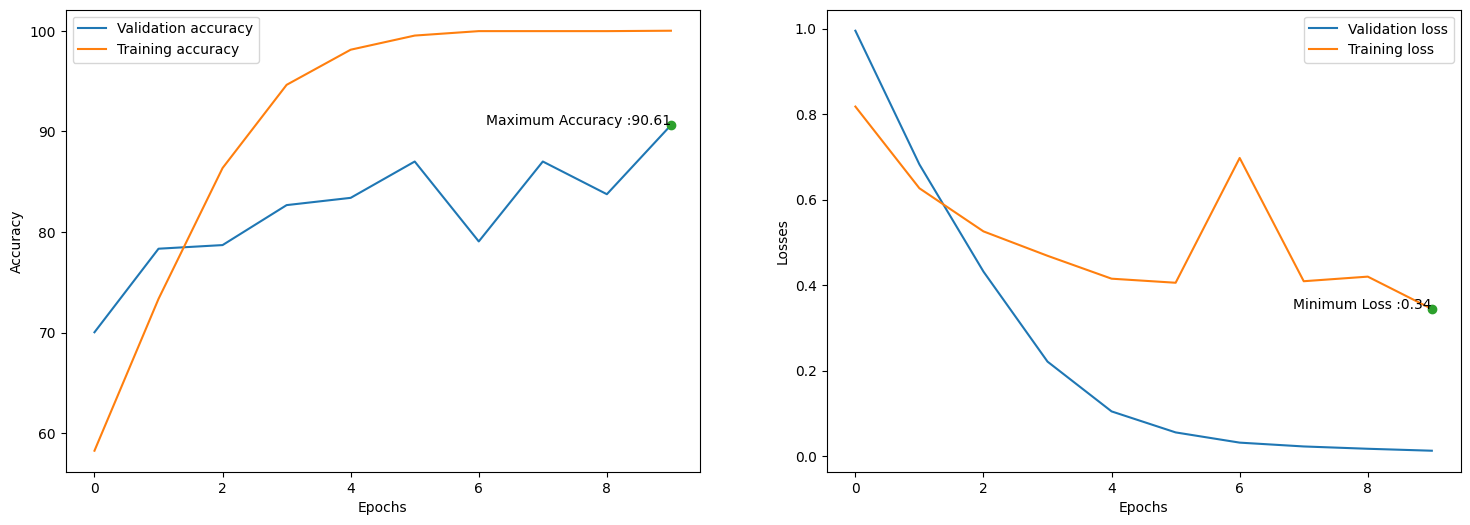

In [43]:
acc_max=np.argmax(val_accs)
loss_min=np.argmin(val_losss)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(val_accs,label="Validation accuracy")
plt.plot(train_accs,label="Training accuracy")
plt.text(acc_max,val_accs[acc_max],"Maximum Accuracy :"+ str(np.around(val_accs[acc_max].numpy(), decimals=2)),ha='right')
plt.plot(acc_max,val_accs[acc_max],'o') 
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.plot(train_losss,label="Validation loss")
plt.plot(val_losss,label="Training loss")
plt.text(loss_min,val_losss[loss_min],"Minimum Loss :"+ str(np.around(val_losss[loss_min], decimals=2)),ha='right')
plt.plot(loss_min,val_losss[loss_min],'o') 
plt.legend()
plt.show()